# HWK2 

## You are expected to characterize data taken from TESS of star TOI 216.

we will be using the data from 

## 1. Available data

You


## 2. New data

You will be accessing data from the MAST repository

In [1]:
# Make sure you have these dependencies available
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. We first download data on TESSCut FFI Cutouts

For this tutorial we will use the TESS images from sector 1. We will request the 
cutout of a star that has been found to have two orbiting planets. The size of each
stamp is 50x50 in this case.

We data being downloaded is first download the FFI data. This is done by providing the target (a name or angle position), and a sector. Notice that if you don't know the sector you can leave that blank. 


In [149]:
target = 'TOI216'  # TOI 216 Star
tpf = lk.search_tesscut(target, sector=1).download(cutout_size=(50, 50))

In [ ]:
# These TESS cut objects provide tons of capabilities. In particular, one can see the
# animation of such data...
tpf.animate()

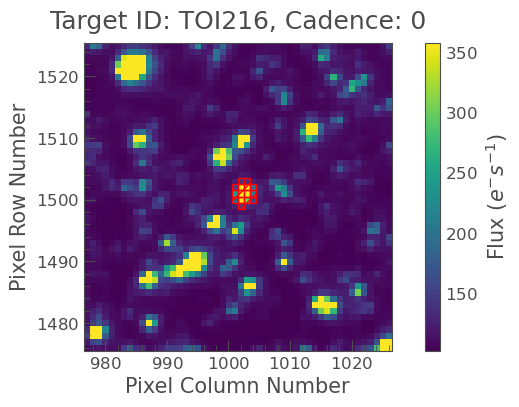

In [151]:
# Now we must create a mask for that star. This is the
aper = tpf.create_threshold_mask()
# And see what it looks like
tpf.plot(aperture_mask=aper);

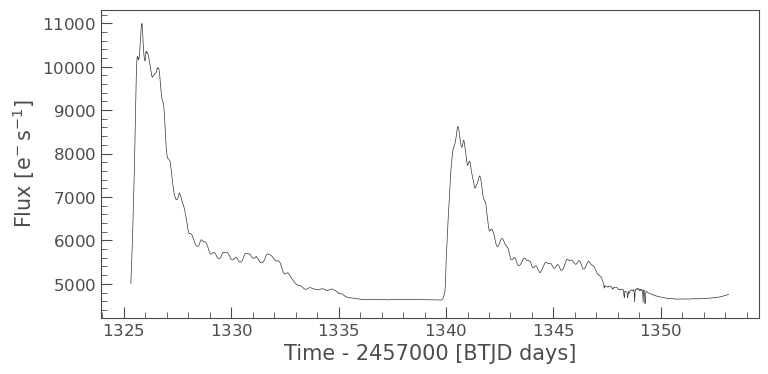

In [152]:
# Now we sum all those pixels
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)
uncorrected_lc.plot();

This is clearly the effect of scattered light from the Moon or the Earth on our lightcurve.

In order to remove that effect we can try and correct using the values of the pixels that are not associated with our aperture.

There are these many pixels 2485 in back, and 1267 times 


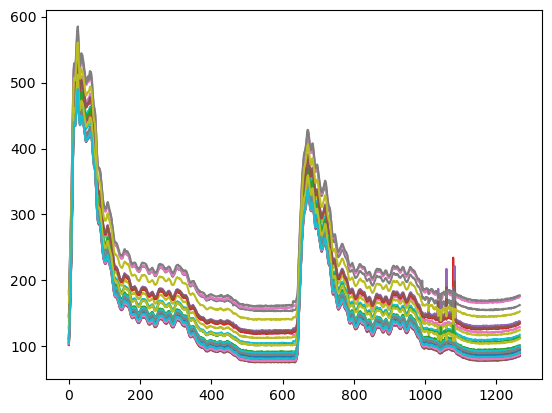

In [153]:
back = tpf.flux[:, ~aper]
ntimes,npix=back.shape
print('There are these many pixels %d in back, and %d times '%(npix, ntimes))
# Now we plot the first 30 lightcurves
fig=plt.figure()
plt.plot(back[:, :30]);

In [154]:
# back is of type Quantity, in order to use, let's try
# and compute the median of these
trend = np.median(back, axis=1)

In [157]:
trend.value

array([110.968   , 126.14002 , 144.33849 , ...,  92.74178 ,  92.968704,
        93.08097 ], dtype=float32)

[]

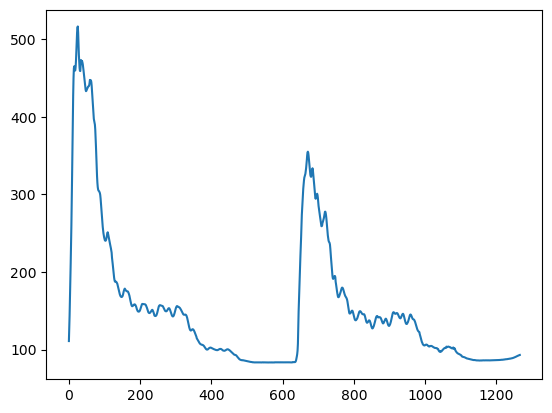

In [160]:
fig = plt.figure()
plt.plot(trend.value)
plt.plot()

In [163]:
# from the uncorrected_lc (sum of all values in aperture pixels)
# we subtract the number of pixels (aper.sum()) times the trend we just computed
median_subtracted_lc = uncorrected_lc - aper.sum()*trend

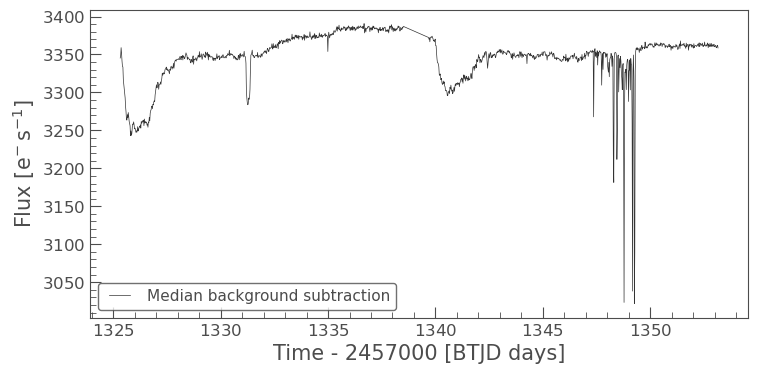

In [165]:
ax = median_subtracted_lc.plot(label='Median background subtraction')

## 2. Now we consider TESS' 2 minute cadence

In each TESS field a number of stars were designated as TESS Object of Interest, or TOI. Photometry from these were computed every 2 minutes and saved as a lightcurve, besides the Full Frame Images (FFI) that you accessed in part 1.

In [166]:
# Download a 2-minute cadence Target Pixel File (TPF)
tpf_2min = lk.search_targetpixelfile(target, mission='TESS', sector=1).download()

/Users/cfuentes/anaconda3/lib/python3.11/site-packages/lightkurve/search.py:423: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


In [168]:
# Use the pipeline aperture and an uncorrected light curve
# The aperture has already been computed and the lightcurve has been detrended
aper = tpf_2min.pipeline_mask
twomin_lc = tpf_2min.to_lightcurve()

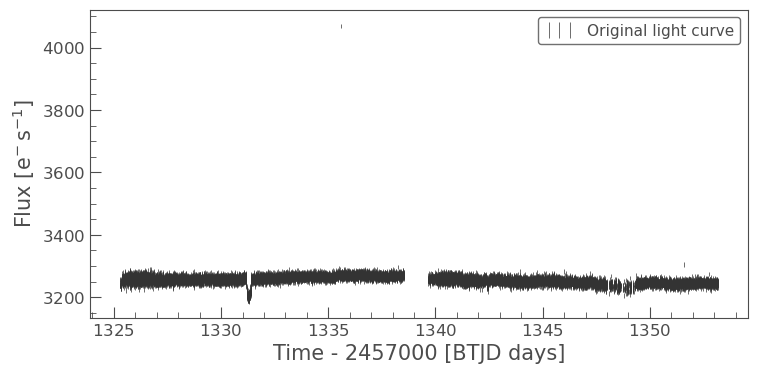

In [175]:
%matplotlib inline
ax = twomin_lc.errorbar(label='Original light curve')

In [210]:


def flux_at_time(t, F, Rp, Rs, c, t_ingress, t_duration, Period):
    """
    Calculate the flux at a given time during the transit.
    Parameters:
    - t: current time
    - F: flux from the star out of transit
    - Rp: radius of the planet
    - Rs: radius of the star
    - c: linear limb-darkening coefficient
    - t_ingress: time of ingress
    - t_duration: full duration of the transit
    Returns:
    - F_t: flux at time t
    """
    t_med = t_ingress+t_duration/2.
    r = Rs*2*(t-t_med)/t_duration
    lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)
    
    depth = (Rp / Rs)**2 * (1 + c * lambda_val)
    delta_F = F * depth
    t_egress = t_ingress + t_duration
    if t < t_ingress or t > t_egress:
        return F
    else:
        return F - delta_F



/var/folders/c_/djjlvx991jz1m2pr1d6gn8400000gn/T/ipykernel_96416/3597918070.py:17: RuntimeWarning: invalid value encountered in sqrt
  lambda_val = np.sqrt((Rs**2-r**2)/Rs**2)


<IPython.core.display.Javascript object>


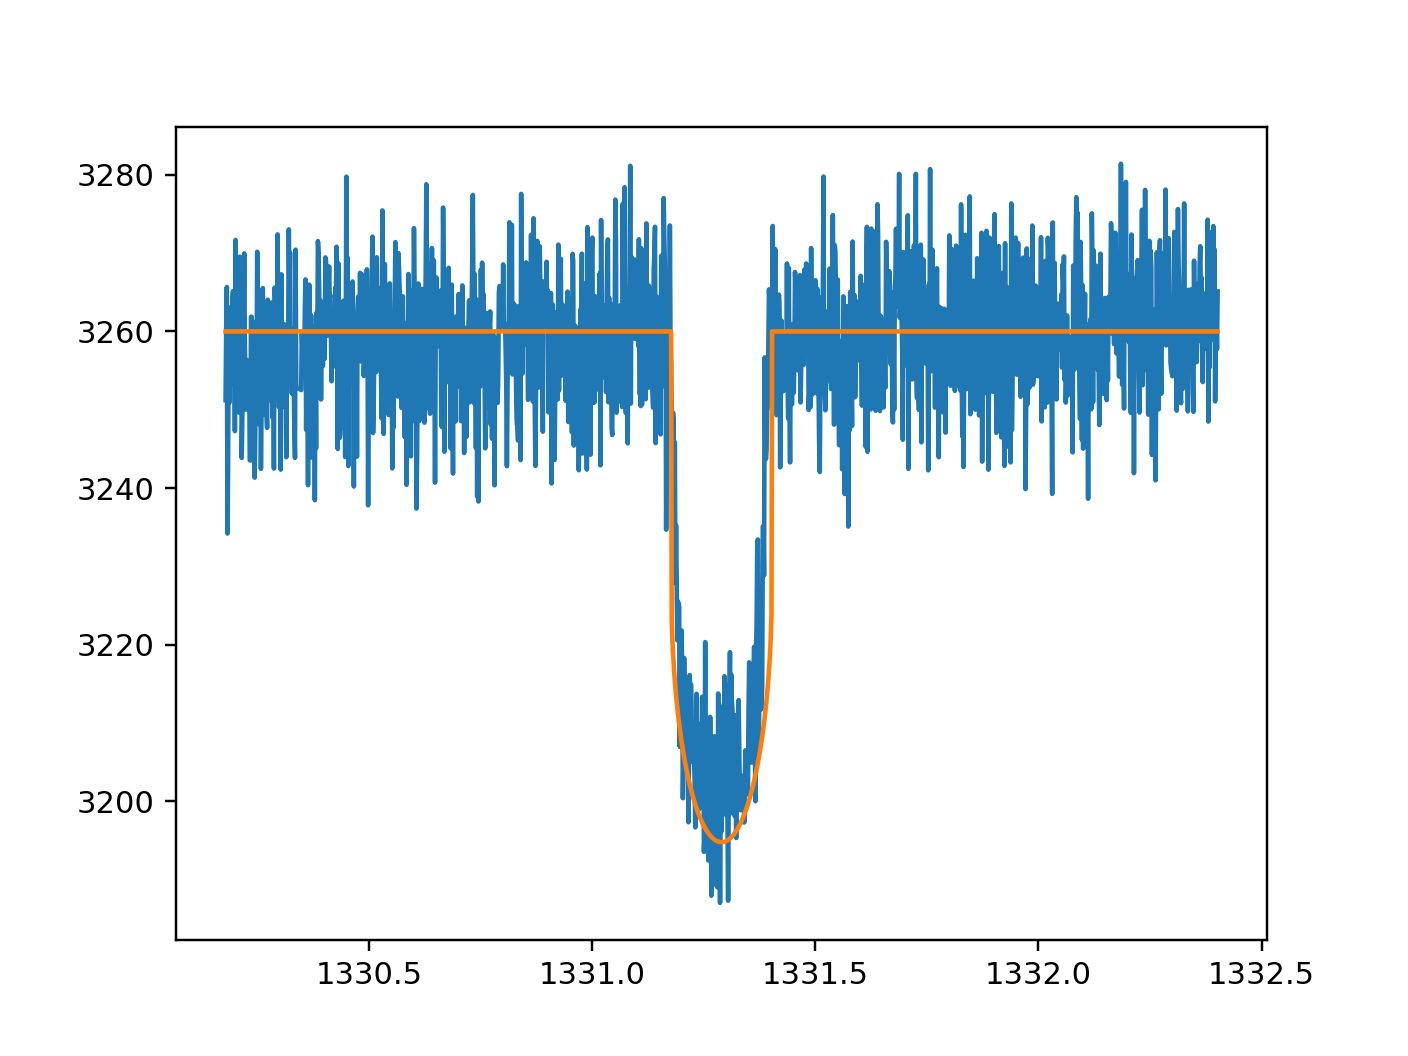

In [214]:
%matplotlib widget
F, Rp, Rs, c, t_ingress, t_duration, Period = 3260, .1, 1, 1, 1331.177, 0.2252, 10
mod = [flux_at_time(t,F, Rp, Rs, c, t_ingress, t_duration, Period) for t in twomin_lc['time'].btjd]

fig = plt.figure()
filt = (twomin_lc['time'].btjd>t_ingress-1.) * (twomin_lc['time'].btjd<t_ingress+t_duration+1.)
plt.plot(twomin_lc['time'].btjd[filt], twomin_lc['flux'][filt])
plt.plot(twomin_lc['time'].btjd[filt], np.array(mod)[filt])
